In [116]:
import numpy as np
import pandas as pd
import math
import datetime
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math

# 数据预处理

In [117]:
class preProcess():
    def __init__(self, file, city):
        self.data = file[file['城市'] == city]
        Infection = self.data.groupby('报道时间')['新增确诊'].sum()
        Recovered = self.data.groupby('报道时间')['新增出院'].sum()
        Dead = self.data.groupby('报道时间')['新增死亡'].sum()
        self.data = {'报道时间':Infection.index, '新增确诊':Infection.values, '新增出院': Recovered.values, '新增死亡':Dead.values}
        self.data = pd.DataFrame(self.data, index = [i for i in range(Infection.shape[0])])
    
    def getTotal(self):
        self.removeNoisyData()
        TotalInfection = [self.data.loc[0:i,'新增确诊'].sum() for i in range(self.data.shape[0])]
        TotalRecovered = [self.data.loc[0:i,'新增出院'].sum() for i in range(self.data.shape[0])]
        TotalDead = [self.data.loc[0:i,'新增死亡'].sum() for i in range(self.data.shape[0])]
        self.data = self.data.join(pd.DataFrame([TotalInfection,TotalRecovered ,TotalDead], index = ['累计确诊', '累计出院','累计死亡']).T)
        #return self.data
        print(self.data)
    
    def removeNoisyData(self):
        self.data = self.data[self.data['报道时间'] >= '1月18日']
        self.data.index = [i for i in range(self.data.shape[0])]
        
    def report(self):
        plt.plot(self.data.index, self.data['累计确诊'])
        plt.xlabel('Day')
        plt.ylabel('Number of people')
        plt.show()

# 模型

In [159]:
class SIRModel():
    def __init__(self, N, beta, gamma, contacts):
        self.beta, self.gamma, self.N = beta, gamma, N
        self.t = np.linspace(0, 360, 361)
        self.setInitCondition()
        self.contacts = contacts
    
    def odeModel(self, population, t):
        diff = np.zeros(3)
        s,i,r = population
        diff[0] = - self.beta * s * i / self.N
        diff[1] = self.beta * s * i / self.N - self.gamma * i
        diff[2] = self.gamma * i
        return diff
    
    def setInitCondition(self):
        self.populationInit = [self.N - 1, 1, 0]
        
    def solve(self):
        self.solution = odeint(self.odeModel,self.populationInit,self.t)
    
    def report(self):
        plt.plot(self.solution[:,1],color = 'orange',label = 'Infection',marker = '.')
        plt.plot(self.solution[:,2],color = 'green',label = 'Recovery',marker = '.')
        plt.title('SIR Model' + ' contacts= '+ str(self.contacts))
        plt.legend()
        plt.xlabel('Day')
        plt.ylabel('Number of people')
        plt.show()

# 参数拟合

从上面的模型看出只有两个变量:$\beta$和$\gamma$，因此我们需要利用已知的数据来拟合得到这两个参数。
我们选取1月18日至1月28日的数据来辨识传染概率$\beta$注：为何选取18日至28日的数据？因为武汉封城是在23日，在封城之前疾病的传播受到人为因素影响较小，所以采用封城前的数据来做参数辨识。同时由于18日之前武汉患病数据可能并不真实（有瞒报情况），所以18日之前的数据也不采用。 武汉第一例病例发现为12月8日，所以将12月8日作为开始时间，到1月18日经历了41天。

In [160]:
def get_beta(y, gama, dataStartTimeStep):
    x = list(range(dataStartTimeStep,len(y)+dataStartTimeStep))
    m = sum([a*b for a,b in zip(x, y)])
    n = sum([a*a for a in x])
    beta = m/n+gamma
    print('beta的值为：',beta)
    print('prob的值为：',beta / 5)
    return beta, beta/5.0

# 主函数

     报道时间  新增出院  新增死亡  新增确诊   累计确诊  累计出院  累计死亡
0   1月18日     3     0     4      4     3     0
1   1月19日     4     0    17     21     7     0
2   1月20日     6     2   136    157    13     2
3   1月21日     0     2    60    217    13     4
4   1月22日     3    11   167    384    16    15
5   1月24日     3     6    70    454    19    21
6   1月25日     1    15    77    531    20    36
7   1月26日     8     7    46    577    28    43
8   1月27日     2    18    80    657    30    61
9   1月28日     3    22   892   1549    33    83
10  1月29日    30    19   315   1864    63   102
11  1月30日     7    25   356   2220    70   127
12  1月31日    21    30   378   2598    91   157
13  2月10日   167    73  1920   4518   258   230
14  2月11日   162    67  1552   6070   420   297
15  2月12日   171    72  1104   7174   591   369
16   2月1日    36    33   576   7750   627   402
17   2月2日    32    32   894   8644   659   434
18   2月3日    53    41  1033   9677   712   475
19   2月4日    79    48  1242  10919   791   523
20   2月5日    

/home/linbang/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


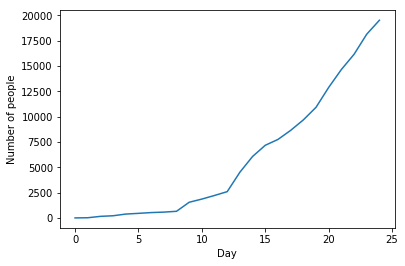

In [161]:
file = pd.read_csv('Updates_NC.csv', encoding='gbk')
city = '武汉市'
data = preProcess(file,city)
data.getTotal()
data.report()

In [162]:
dataStartTimeStep = 41
dataLengthStep = 10
y = [math.log(d) for d in data.data['累计确诊'].values[:dataLengthStep]]
gamma = 1/14
beta, prob = get_beta(y,gamma, dataStartTimeStep)

beta的值为： 0.19042344528326258
prob的值为： 0.038084689056652514


/home/linbang/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


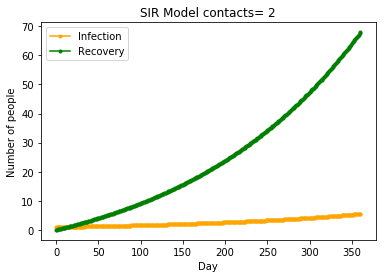

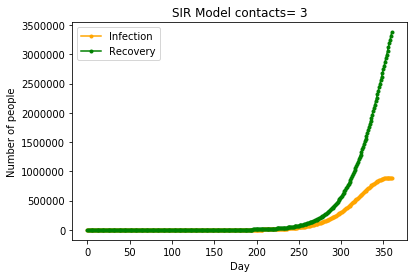

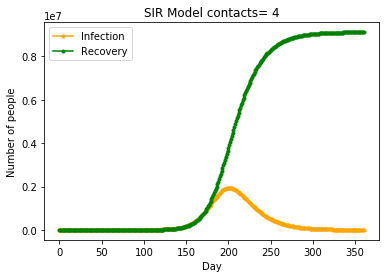

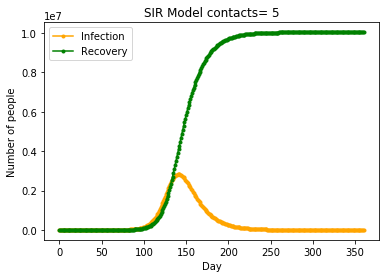

In [163]:
#不同的k表示一个病人密切接触者的平均数量，越小代表控制的越严格
for k in range(2,6):
    beta, gamma, N = k * prob,1/14,1.1 * 10**7
    SIRModel_ = SIRModel(N, beta, gamma, k)
    SIRModel_.solve()
    SIRModel_.report()